In [0]:
import os, cv2
import numpy as np
#import cPickle
import _pickle as cPickle
import pandas as pd 
from numpy import argmax
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential 
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.python.keras.applications import Xception, VGG16
from tensorflow.python.keras.layers import Dense, Activation, Dropout, Flatten, GaussianNoise,GlobalAveragePooling2D
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D,InputLayer
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import regularizers
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
K.set_learning_phase(1) 
from scipy.misc import imsave
import keras
from keras.applications import vgg16
from keras.optimizers import Adam

In [73]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
os.chdir("/content/gdrive/My Drive/Colab Notebooks")

In [0]:
import scipy.misc

for i in range(len(U2_gray_2[500:])):
  scipy.misc.imsave("Good_gray" + str(i+500) + ".jpg", U2_gray_2[i])

Importing train and validation folders from Google Drive, previous cell stored Numpy arrays of image data gathered from ImageSearch notebook in Good and NG folders

In [0]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) 
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) 


train_generator=train_datagen.flow_from_directory('U2_gray/train', 
                                                 target_size=(500,500),
                                                 color_mode='rgb',
                                                 batch_size=1,
                                                 class_mode='categorical',
                                                 shuffle=True)

val_generator=val_datagen.flow_from_directory('U2_gray/val',
                                                 target_size=(500,500),
                                                 color_mode='rgb',
                                                 batch_size=1,
                                                 class_mode='categorical',
                                                 shuffle=True)



Found 635 images belonging to 2 classes.
Found 317 images belonging to 2 classes.


Code adapted from: https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e

Flow from directory determines categories based on amount of folders within directory and assigns label to each image according to its directory

In [33]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=(500,500,3))

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

#vgg_model.trainable = False
#for layer in vgg_model.layers:
#    layer.trainable = False
for layer in vgg_model.layers[:16]:
    layer.trainable=False
for layer in vgg_model.layers[16:]:
    layer.trainable=True

input_shape = vgg_model.output_shape[1]

vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 500, 500, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 125, 125, 128)     0         
__________

Code adapted from: https://riptutorial.com/keras/example/32608/transfer-learning-using-keras-and-vgg

VGG16 Network with the last couple layers left as trainable on the dataset to act as feature recognition.

In [34]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='elu', input_dim=input_shape))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=5e-6),
              metrics=['accuracy',recall])
              
history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator), epochs=30,
                              validation_data=val_generator, validation_steps=len(val_generator), 
                              verbose=1)   

Epoch 1/30
635/635 [==============================] - 129s 204ms/step - loss: 0.2539 - acc: 0.8874 - recall: 0.8913 - val_loss: 0.3240 - val_acc: 0.8707 - val_recall: 0.8675
Epoch 2/30
635/635 [==============================] - 127s 200ms/step - loss: 0.1130 - acc: 0.9591 - recall: 0.9622 - val_loss: 0.0946 - val_acc: 0.9700 - val_recall: 0.9653
Epoch 3/30
635/635 [==============================] - 127s 200ms/step - loss: 0.0688 - acc: 0.9780 - recall: 0.9780 - val_loss: 0.1936 - val_acc: 0.9495 - val_recall: 0.9495
Epoch 4/30
635/635 [==============================] - 127s 200ms/step - loss: 0.0627 - acc: 0.9835 - recall: 0.9843 - val_loss: 0.1200 - val_acc: 0.9685 - val_recall: 0.9716
Epoch 5/30
635/635 [==============================] - 127s 200ms/step - loss: 0.0579 - acc: 0.9850 - recall: 0.9858 - val_loss: 0.1168 - val_acc: 0.9732 - val_recall: 0.9716
Epoch 6/30
635/635 [==============================] - 127s 200ms/step - loss: 0.0426 - acc: 0.9890 - recall: 0.9906 - val_loss: 0.

In [0]:
def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


Code taken from: https://github.com/GeekLiB/keras/blob/master/keras/metrics.py

In [0]:
def show_curve(history):
    plt.plot(history.history['val_recall'])
    plt.plot(history.history['val_acc'])
    plt.plot(history.history['acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['recall', 'test', 'train'], loc='upper left')
    plt.show()

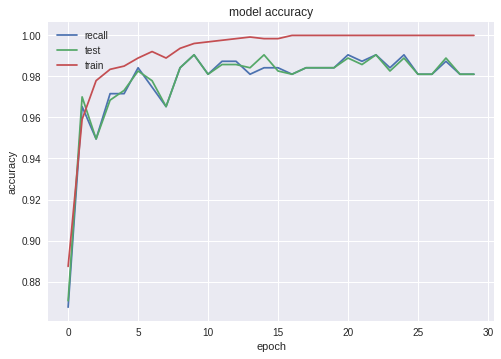

In [35]:
show_curve(history)

In [109]:
os.chdir("/content/gdrive/My Drive/Colab Notebooks")
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
test_generator=test_datagen.flow_from_directory('U2_gray/test',
                                                 target_size=(500,500),
                                                 color_mode='rgb',
                                                 batch_size=1,
                                                 class_mode='categorical',
                                                 shuffle=False)

Found 130 images belonging to 2 classes.


In [0]:
Tru = test_generator.labels

In [112]:
predictions = model.predict_generator(test_generator,steps = 130, verbose = 1)

130/130 [==============================] - 12s 93ms/step


In [113]:
for i in range(len(Tru)):
	print("X=%s, Actual=%s" % (predictions[i], Tru[i]))

X=[1.0000000e+00 2.6082082e-16], Actual=0
X=[1.0000000e+00 1.5357802e-16], Actual=0
X=[1.0000000e+00 1.8376394e-16], Actual=0
X=[1.0000000e+00 1.8077146e-16], Actual=0
X=[1.000000e+00 5.797364e-17], Actual=0
X=[1.000000e+00 9.506422e-09], Actual=0
X=[1.000000e+00 1.644321e-08], Actual=0
X=[1.0000000e+00 1.1821121e-12], Actual=0
X=[1.000000e+00 9.738085e-12], Actual=0
X=[1.0000000e+00 3.9328383e-16], Actual=0
X=[1.0000000e+00 1.5907261e-13], Actual=0
X=[1.00000e+00 6.22967e-14], Actual=0
X=[1.0000000e+00 5.0465426e-12], Actual=0
X=[1.0000000e+00 2.6537373e-12], Actual=0
X=[1.0000000e+00 2.8855222e-11], Actual=0
X=[1.0000000e+00 1.1505068e-13], Actual=0
X=[1.000000e+00 3.939949e-12], Actual=0
X=[1.000000e+00 4.385257e-12], Actual=0
X=[1.0000000e+00 5.1104235e-16], Actual=0
X=[1.0000000e+00 8.4057686e-14], Actual=0
X=[1.0000000e+00 7.1549715e-12], Actual=0
X=[1.000000e+00 9.567723e-13], Actual=0
X=[1.0000000e+00 1.0994905e-11], Actual=0
X=[1.0000000e+00 1.2044452e-13], Actual=0
X=[1.00000

Comparing predicted results to expected results from test set, which model has never seen before. 25/26 defects were correctly identified and 104/104 good images were identified as such.